<a href="https://colab.research.google.com/github/lili-codelab/comp-linguistics/blob/main/convnet_pr_li.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практический семинар: CNN для Fashion-MNIST

1.  Подготовка данных
2.  Архитектура "учителя" (образец)
3.  **Ваша модель** (практика)
4.  Обучение и оценка
5.  Эксперимент


## Часть 1: загрузка и подготовка данных

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# 1. Загрузка Fashion-MNIST
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

# 2. Нормализация (делим на 255)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# 3. Преобразуем метки в one-hot encoding (готовый код)
y_train_cat = keras.utils.to_categorical(y_train, 10)
y_test_cat = keras.utils.to_categorical(y_test, 10)

# 4. Добавляем размерность канала (для Conv2D)
x_train = np.expand_dims(x_train, axis=-1)  # (60000,28,28,1)
x_test = np.expand_dims(x_test, axis=-1)    # (10000,28,28,1)

print(f"x_train shape: {x_train.shape}")
print(f"y_train_cat shape: {y_train_cat.shape}")

# Словарь классов
class_names = ['Футболка', 'Брюки', 'Свитер', 'Платье', 'Пальто',
               'Сандаль', 'Рубашка', 'Кроссовок', 'Сумка', 'Ботильон']

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28, 1)
y_train_cat shape: (60000, 10)


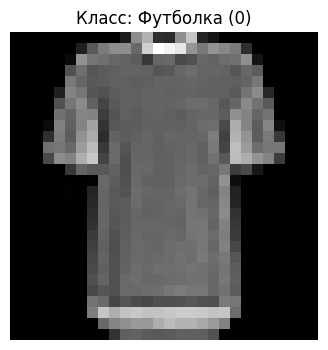

Индекс: 12183
Размер изображения: (28, 28, 1)
Метка (число): 0
Метка (текст): Футболка


In [4]:
# Визуализация случайного изображения
import random

# Случайный индекс
idx = random.randint(0, len(x_train) - 1)

# Получаем изображение и метку
image = x_train[idx]
label = y_train[idx]

# Создаем график
plt.figure(figsize=(4, 4))
plt.imshow(image.squeeze(), cmap='gray')  # Убираем размерность канала для отображения
plt.title(f"Класс: {class_names[label]} ({label})")
plt.axis('off')
plt.show()

# Дополнительная информация
print(f"Индекс: {idx}")
print(f"Размер изображения: {image.shape}")
print(f"Метка (число): {label}")
print(f"Метка (текст): {class_names[label]}")

## Часть 2: архитектура 'Учителя' (образец)

In [5]:
# Модель 'Учитель'
teacher_model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

teacher_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

### Вопросы для понимания (обсудите в группе или ответьте письменно):
1.  **Flatten:** Зачем нужен этот слой? Что он делает с данными?
2.  **MaxPooling2D:** Какую функцию выполняет? Почему он следует за Conv2D?
3.  **Последний Dense слой:** Почему в нём 10 нейронов и активация `softmax`?

---

## Часть 3: ваша модель (практика сборки)

**Задание:** соберите CNN **точно по этой спецификации**:
1.  Conv2D: 16 фильтров, размер 3x3, активация `relu`, `input_shape=(28,28,1)`
2.  MaxPooling2D: пул 2x2
3.  Conv2D: 32 фильтра, 3x3, `relu`
4.  MaxPooling2D: 2x2
5.  Flatten
6.  Dense: 64 нейрона, `relu`
7.  Dense: 10 нейронов, `softmax`

**Заполните пропуски ниже**

In [15]:
# Ваша модель (студент)
student_model = keras.Sequential([
    # Слой 1: Conv2D (16 фильтров, 3x3, relu, правильный input_shape)
    keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)),

    # Слой 2: MaxPooling2D (2,2)
    keras.layers.MaxPooling2D((2,2)),

    # Слой 3: Conv2D (32 фильтра, 3x3, relu)
     keras.layers.Conv2D(32, (3,3), activation='relu'),

    # Слой 4: MaxPooling2D (2,2)
    keras.layers.MaxPooling2D((2,2)),

    # Слой 5: Flatten
    keras.layers.Flatten(),

    # Слой 6: Dense (64 нейрона, relu)
    keras.layers.Dense(64, activation='relu'),

    # Слой 7: Dense (10 нейронов, softmax)
    keras.layers.Dense(10, activation='softmax')
    ])

student_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,714 (221.54 KB)

 Trainable params: 56,714 (221.54 KB)

 Non-trainable params: 0 (0.00 B)

---

## Часть 4: компиляция и обучение

In [16]:
# Учитель: компиляция
teacher_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

In [17]:
# Учитель: обучение (5 эпох)
teacher_history = teacher_model.fit(x_train, y_train,  # Используем исходные метки (не one-hot)
                                    epochs=5,
                                    validation_split=0.2,
                                    verbose=1)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - accuracy: 0.9277 - loss: 0.1925 - val_accuracy: 0.9033 - val_loss: 0.2636
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 44s 30ms/step - accuracy: 0.9381 - loss: 0.1686 - val_accuracy: 0.9121 - val_loss: 0.2552
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - accuracy: 0.9460 - loss: 0.1448 - val_accuracy: 0.9089 - val_loss: 0.2755
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 43s 29ms/step - accuracy: 0.9516 - loss: 0.1312 - val_accuracy: 0.9114 - val_loss: 0.2683
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 46s 31ms/step - accuracy: 0.9563 - loss: 0.1151 - val_accuracy: 0.9052 - val_loss: 0.3078


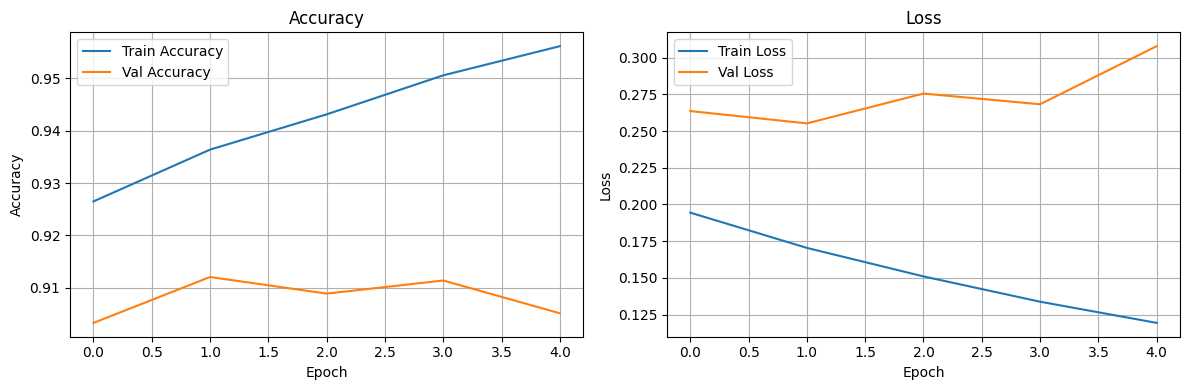

In [18]:
# Визуализация процесса обучения
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# График точности
axes[0].plot(teacher_history.history['accuracy'], label='Train Accuracy')
axes[0].plot(teacher_history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# График потерь
axes[1].plot(teacher_history.history['loss'], label='Train Loss')
axes[1].plot(teacher_history.history['val_loss'], label='Val Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

**Задание:**
1.  Скомпилируйте `student_model` с оптимизатором **`sgd`**
2.  Добавьте метрику **`'sparse_top_k_categorical_accuracy'`** к списку метрик
3.  Обучите модель на **3 эпохи** с `validation_split=0.2`
4.  Постройте график обучения

Epoch 1/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 35s 23ms/step - accuracy: 0.5184 - loss: 1.3685 - sparse_top_k_categorical_accuracy: 0.9207 - val_accuracy: 0.7716 - val_loss: 0.6175 - val_sparse_top_k_categorical_accuracy: 0.9939
Epoch 2/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 22ms/step - accuracy: 0.7724 - loss: 0.6106 - sparse_top_k_categorical_accuracy: 0.9942 - val_accuracy: 0.7910 - val_loss: 0.5599 - val_sparse_top_k_categorical_accuracy: 0.9933
Epoch 3/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 34s 23ms/step - accuracy: 0.8065 - loss: 0.5232 - sparse_top_k_categorical_accuracy: 0.9957 - val_accuracy: 0.8175 - val_loss: 0.5109 - val_sparse_top_k_categorical_accuracy: 0.9954


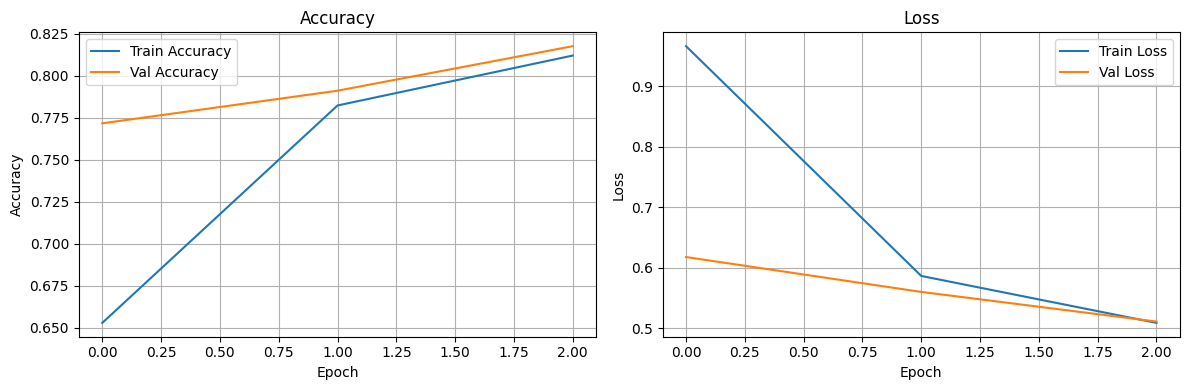

In [19]:
# 1. Компиляция вашей модели (sgd, sparse_categorical_crossentropy, accuracy + sparse_top_k_categorical_accuracy)
student_model = keras.Sequential([
    keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
    ])

student_model.compile(optimizer='sgd',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy', SparseTopKCategoricalAccuracy(k=5,
name='sparse_top_k_categorical_accuracy')])

# 2. Обучение (3 эпохи, validation_split=0.2)
student_history = student_model.fit(x_train, y_train,
                                    epochs=3,
                                    validation_split=0.2,
                                    verbose=1)

# 3. График обучения
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# График точности (accuracy + top-5)
axes[0].plot(student_history.history['accuracy'], label='Train Accuracy')
axes[0].plot(student_history.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# График потерь
axes[1].plot(student_history.history['loss'], label='Train Loss')
axes[1].plot(student_history.history['val_loss'], label='Val Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

---

## Часть 5: оценка и сравнение моделей

In [12]:
from sklearn.metrics import classification_report

# 1. Оценка точности на тесте
teacher_test_loss, teacher_test_acc = teacher_model.evaluate(x_test, y_test, verbose=0)
print(f"\nМодель 'Учитель' на тесте:")
print(f"  Loss:     {teacher_test_loss:.4f}")
print(f"  Accuracy: {teacher_test_acc:.4f}")

# 2. Подробный отчёт
y_pred_teacher = teacher_model.predict(x_test)
y_pred_classes_teacher = np.argmax(y_pred_teacher, axis=1)
print("\nОтчёт classification_report для учителя:")
print(classification_report(y_test, y_pred_classes_teacher, target_names=class_names))


Модель 'Учитель' на тесте:
  Loss:     0.2722
  Accuracy: 0.9026
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Отчёт classification_report для учителя:
              precision    recall  f1-score   support

    Футболка       0.88      0.82      0.85      1000
       Брюки       1.00      0.97      0.98      1000
      Свитер       0.81      0.89      0.85      1000
      Платье       0.89      0.93      0.91      1000
      Пальто       0.83      0.87      0.85      1000
     Сандаль       0.98      0.98      0.98      1000
     Рубашка       0.77      0.67      0.71      1000
   Кроссовок       0.97      0.92      0.95      1000
       Сумка       0.96      0.99      0.97      1000
    Ботильон       0.94      0.98      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



**Задание:**
1.  Оцените вашу модель (`student_model`) на тестовых данных. Получите `loss` и `accuracy`.
2.  Сравните accuracy с моделью учителя. Какая лучше и почему (возможные причины)?
3.  Выведите `classification_report` для вашей модели.


In [20]:
# 1. Оценка точности вашей модели на тесте
test_results = student_model.evaluate(x_test, y_test, verbose=0)
student_test_loss, student_test_acc, student_test_top5 = test_results[:3]

# 2. Сравнение
print(f"\nСравнение точности на тесте:")
print(f"  Учитель (adam):  {teacher_test_acc:.4f}")
print(f"  Ваша модель (sgd): {student_test_acc:.4f}")

# 3. Отчёт classification_report для вашей модели
y_pred_student = student_model.predict(x_test)
y_pred_classes_student = np.argmax(y_pred_student, axis=1)
print(classification_report(y_test, y_pred_classes_student, target_names=class_names))


Сравнение точности на тесте:
  Учитель (adam):  0.9026
  Ваша модель (sgd): 0.8056
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

    Футболка       0.75      0.82      0.78      1000
       Брюки       0.99      0.95      0.97      1000
      Свитер       0.54      0.83      0.66      1000
      Платье       0.81      0.86      0.83      1000
      Пальто       0.67      0.69      0.68      1000
     Сандаль       0.96      0.91      0.93      1000
     Рубашка       0.65      0.17      0.27      1000
   Кроссовок       0.87      0.94      0.91      1000
       Сумка       0.91      0.95      0.93      1000
    Ботильон       0.95      0.94      0.94      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.79     10000
weighted avg       0.81      0.81      0.79     10000



---

## Часть 6: эксперимент

**Задание:** модифицируйте вашу модель `student_model`, добавив слой **`Dropout(0.3)`** после первого `Dense`-слоя (с 64 нейронами). Переобучите модель на 3 эпохи. Как изменилась точность на валидации и тесте? Стала ли модель лучше обобщаться?

*Подсказка: используйте `keras.layers.Dropout(0.3)`.*


Epoch 1/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.4539 - loss: 1.5220 - sparse_top_k_categorical_accuracy: 0.8810 - val_accuracy: 0.7398 - val_loss: 0.6696 - val_sparse_top_k_categorical_accuracy: 0.9934
Epoch 2/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.7267 - loss: 0.7265 - sparse_top_k_categorical_accuracy: 0.9901 - val_accuracy: 0.7736 - val_loss: 0.5766 - val_sparse_top_k_categorical_accuracy: 0.9958
Epoch 3/3
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 26s 17ms/step - accuracy: 0.7670 - loss: 0.6224 - sparse_top_k_categorical_accuracy: 0.9930 - val_accuracy: 0.8037 - val_loss: 0.5143 - val_sparse_top_k_categorical_accuracy: 0.9959


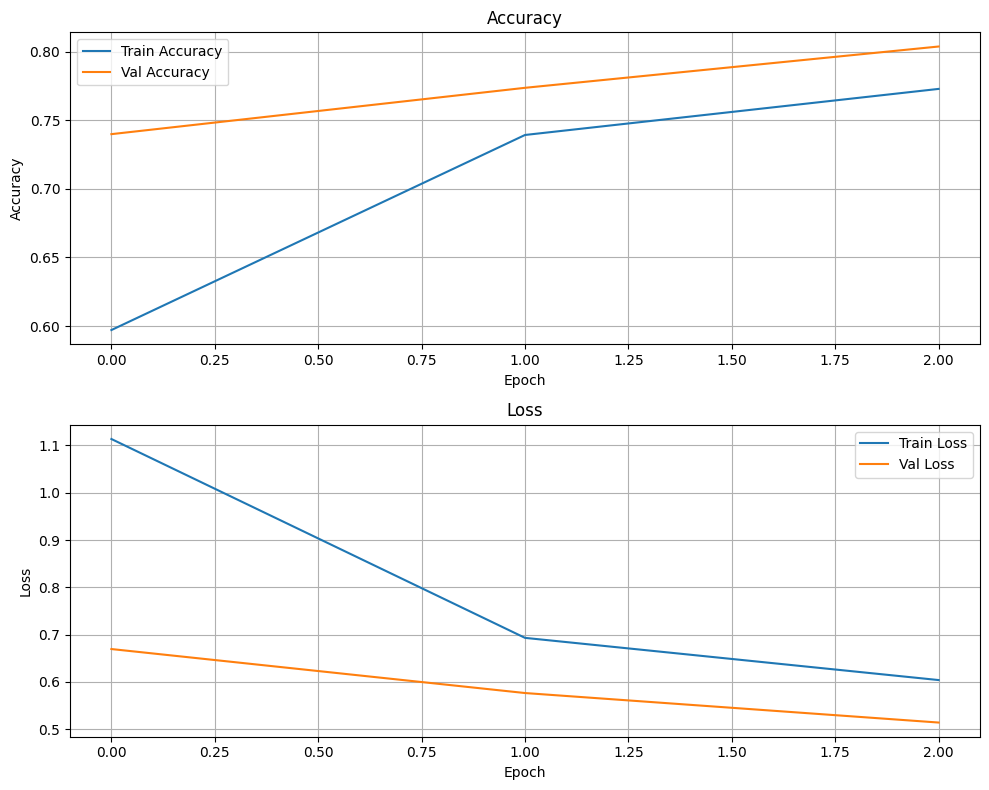

In [31]:
student_model_b = keras.Sequential([
    keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(32, (3,3), activation='relu'),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(10, activation='softmax')
])

student_model_b.compile(optimizer='sgd',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy', SparseTopKCategoricalAccuracy(k=5,
name='sparse_top_k_categorical_accuracy')])

dropout_his = student_model_b.fit(x_train, y_train,
                                        epochs=3,
                                        validation_split=0.2,
                                        verbose=1)

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

axes[0].plot(dropout_his.history['accuracy'], label='Train Accuracy')
axes[0].plot(dropout_his.history['val_accuracy'], label='Val Accuracy')
axes[0].set_title('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(dropout_his.history['loss'], label='Train Loss')
axes[1].plot(dropout_his.history['val_loss'], label='Val Loss')
axes[1].set_title('Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [32]:
test_old = student_model.evaluate(x_test, y_test, verbose=0)[1]
test_new = student_model_b.evaluate(x_test, y_test, verbose=0)[1]

print(f"Val Acc (последняя эпоха):")
print(f"  Без Dropout: {student_history.history['val_accuracy'][-1]:.4f}")
print(f"  С Dropout:   {dropout_his.history['val_accuracy'][-1]:.4f}")
print(f"  Изменение:   {dropout_his.history['val_accuracy'][-1] - student_history.history['val_accuracy'][-1]:+.4f}")

print(f"\nTest Acc:")
print(f"  Без Dropout: {test_old:.4f}")
print(f"  С Dropout:   {test_new:.4f}")
print(f"  Изменение:   {test_new - test_old:+.4f}")

Val Acc (последняя эпоха):
  Без Dropout: 0.8175
  С Dropout:   0.8037
  Изменение:   -0.0138

Test Acc:
  Без Dropout: 0.8770
  С Dropout:   0.7956
  Изменение:   -0.0814


! *последний блок кода - сравнение, подсказанное ИИ-инструментом, поскольку я не совсем поняла, как мне эту задачу решить* !

По результатам сравнения можно сказать следующее: Dropout(0.3) ухудшил обобщение, поскольку расхождение увеличилось. Вохможно, для sgd было заявлено мало эпох, либо Dropout(0.3) не подходит для маленьких моделей. Необходимы дальнейшие настройки.

---

## Итоги семинара

1.  Вы подготовили данные для CNN
2.  Построили модель по спецификации
3.  Сравнили оптимизаторы (`adam` vs `sgd`)
4.  Оценили модель с помощью метрик и отчёта